<h2>Justin Sherwood</h2>
<h3>April 2, 2024  </h3>
<h3>Project 2 Web Scraping using Python, perform data cleaning and analysis</h3>
<h4>The goal of this notebook is to use web scraping to retreive presidential information from Wikipedia.  The data will be cleaned using various techniques then exported into a clean data set file.  Additionally, this will provide the command to explore the data set and to create plots to provide an analysis of the data.</h4>ng

In [53]:
#Import required libraries
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd
import time
from urllib.parse import urljoin
import re
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker

In [54]:
# This is a function to check access to a web URL and to return the response.
# function argument is a URL
def get_web_page(url):
    response = requests.get(url)
    status = response.status_code
    if status == 200:
        return response.text
    else:
        print(f"Received status code {status}")
        return ""

In [55]:
# This is a function to reteive dempgraphic details of a president
# function argument is a unique URL passed from the main procedure.  
# The URL will be specific to a particular president 
def get_personal_details(url):
    # Send a GET request to the URL
    response = get_web_page(url)
    soup1 = bs(response)

    # Find the infobox containing personal details
    infobox = soup1.find("table", class_="infobox")

    # Initialize variables to store personal details
    born = None
    died = None
    vice_presidents = []

    # Extract personal details of the president
    if infobox:
        for key in ["Born", "Died", "Vice President"]:  #only search for these attributes
            header = infobox.find("th", attrs={"class": "infobox-label", "scope": "row"}, string=key)
            if header:
                value = header.find_next_sibling("td")
                if value:
                    if key == "Born" or key == "Died":
                        # Extract only the date from the Born or Died field
                        match = re.search(r"\b(\w+\s\d{1,2},\s\d{4})", value.text.strip())
                        if match:
                            if key == "Born":
                                born = match.group(1)
                            else:
                                died = match.group(1)
                    elif key == "Vice President":
                        # Extract the names of Vice Presidents without dates
                        vice_presidents = re.findall(r"([A-Z][a-z]+\s(?:[A-Z]\.\s)?[A-Z][a-z]+)", value.text.strip())
    return {"Born": born, "Died": died, "Vice President": ", ".join(vice_presidents)}

<h3>This is the main body of the program.  This will use a starting URL and then use beautifulsoup to find the table and extract the 
rows from the table. </h3>
<h3>To retreive the presidential demographics it will pass an URL from the starting page unique to each president and pass it to the get_personal_details function.  The function will return 3 attributes (birth, death and Vice Presidents). </h3>
<h3>Data will be appended and stored in a Pandas dataframe.</h3>

In [56]:
# Find the table containing the presidents' information
url_start = 'https://en.wikipedia.org/wiki/List_of_United_States_federal_executive_orders'
response = get_web_page(url_start)
soup = bs(response)
presidents_table = soup.find("table", class_="wikitable")

# Extract the data from the table
presidents_data = []
for row in presidents_table.find_all("tr")[1:]:
    columns = row.find_all("td")
    if len(columns) > 0:
        president = columns[1].text.strip()
        party = columns[2].text.strip()
        exorder_total = columns[3].text.strip()
        numrange = columns[4].text.strip()
        yrs_office = columns[5].text.strip()
        orders_per_year = columns[6].text.strip()
        term = columns[7].text.strip()
        president_demo = get_personal_details(urljoin(url_start, columns[1].find('a')['href'])) #retrieves data from 45 different pages 
        presidents_data.append((president, party, exorder_total, yrs_office, orders_per_year, term, president_demo["Born"], president_demo["Died"], president_demo["Vice President"]))

# Creating a pandas DataFrame
president_df = pd.DataFrame(presidents_data, columns=["President", "Party", "Total Executive Orders", "Years in Office", "Executive Orders per year", "Term Period", "Born", "Died", "Vice President"])

# Displaying the DataFrame
president_df

,President,Party,Total Executive Orders,Years in Office,Executive Orders per year,Term Period,Born,Died,Vice President
0,George Washington,Unaffiliated,8,7.95,1.0,"April 30, 1789 – March 4, 1797","February 22, 1732","December 14, 1799",John Adams
1,John Adams,Federalist,1,4,0.3,"March 4, 1797 – March 4, 1801","October 30, 1735","July 4, 1826",Thomas Jefferson
2,Thomas Jefferson,Democratic-Republican,4,8,0.5,"March 4, 1801 – March 4, 1809","April 13, 1743","July 4, 1826","Aaron Burr, George Clinton"
3,James Madison,Democratic-Republican,1,8,0.1,"March 4, 1809 – March 4, 1817","March 16, 1751","June 28, 1836","George Clinton, Elbridge Gerry"
4,James Monroe,Democratic-Republican,1,8,0.1,"March 4, 1817 – March 4, 1825","April 28, 1758","July 4, 1831",Daniel D. Tompkins
5,John Quincy Adams,Democratic-Republican,3,4,0.8,"March 4, 1825 – March 4, 1829","July 11, 1767","February 23, 1848",John C. Calhoun
6,Andrew Jackson,Democratic,12,8,1.5,"March 4, 1829 – March 4, 1837","March 15, 1767","June 8, 1845","John C. Calhoun, Martin Van"
7,Martin Van Buren,Democratic,10,4,2.5,"March 4, 1837 – March 4, 1841","December 5, 1782","July 24, 1862",Richard Mentor
8,William Henry Harrison,Whig,0,0.08,0.0,"March 4, 1841 – April 4, 1841","February 9, 1773","April 4, 1841",John Tyler
9,John Tyler,Whig,17,3.92,4.3,"April 4, 1841 – March 4, 1845","March 29, 1790","January 18, 1862",


<h3>This starts the data cleaning steps.</h3>
<ol>
  <li>clean and split the term period column</li>
  <li>Update the Present string of the incumbent president to the current date.  This allows date time calculations</li>
  <li>Apply the function to Term Period column and create separate columns for start and end dates</li>
  <li>Drop the term_period column</li>
  <li>Calculate number of terms to the dataset</li>
  <li>Change the datatype on a few columns to aid in the analysis</li>
</ol>


In [57]:
#clean and split the term period column
def extract_dates(term_period):
    if term_period == 'Present':
        return pd.NaT, datetime.now()  # Return NaT (Not a Time) for start date and current datetime for end date
    start_date_str, end_date_str = term_period.split('–')
    start_date = pd.to_datetime(start_date_str.strip())
    end_date = pd.to_datetime(end_date_str.strip())
    return start_date, end_date

# Get today's date as a string in the same format
today_date = datetime.now().strftime("%B %d, %Y")

# Update the "Present" string of the incumbent president to the current date.  This allows date time calculations
president_df['Term Period'] = president_df['Term Period'].str.replace('– Present', '– ' + today_date)

# Apply the function to 'Term Period' column and create separate columns for start and end dates
president_df[['Term Start', 'Term End']] = president_df['Term Period'].apply(extract_dates).apply(pd.Series)

# Drop the 'term_period' column
president_df.drop(columns=['Term Period'], inplace=True)


In [58]:
#change the datatype on a few columns to aid in the analysis
president_df["Total Executive Orders"] = pd.to_numeric(president_df["Total Executive Orders"], errors="coerce")
president_df['Years in Office'] = pd.to_numeric(president_df["Years in Office"], errors="coerce")
president_df["Executive Orders per year"] = pd.to_numeric(president_df["Executive Orders per year"], errors="coerce")

In [59]:
#Calculate number of terms to the dataset
def map_term(years):
    if years <= 4:
        return 1
    elif years <= 8:
        return 2
    else:
        return 3

# Create a new column 'term' based on the mapping function
president_df['Number of Terms'] = president_df['Years in Office'].apply(map_term)


<h3>This starts the data Analysis section.</h3>

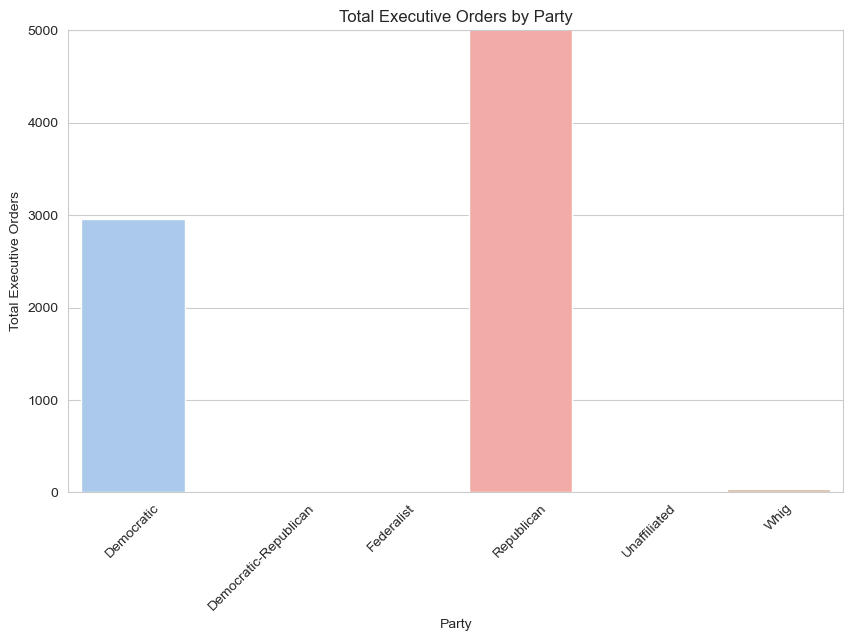

Count of Executive Order by Party:
                   Party  Total Executive Orders
0             Democratic                  2958.0
1  Democratic-Republican                     9.0
2             Federalist                     1.0
3             Republican                  5058.0
4           Unaffiliated                     8.0
5                   Whig                    34.0


In [60]:
#Problem Statement 1 - What is the number of executive orders by party?

# Group the DataFrame by party and sum the total executive orders
executive_orders_by_party = president_df.groupby("Party")["Total Executive Orders"].sum().reset_index()

# Plot the party and sum the total executive orders
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
sns.barplot(data=executive_orders_by_party, x="Party", y="Total Executive Orders", palette="pastel")
plt.title('Total Executive Orders by Party')
plt.xlabel('Party')
plt.ylabel('Total Executive Orders')
plt.xticks(rotation=45)

# Set y-axis limits
plt.ylim(0, 5000)

plt.show()

# Print the Executive Order by Party
print("Count of Executive Order by Party:")
print(executive_orders_by_party)



<h3>Analysis of Question 1</h3>

<h4>Problem Statement - What is the number of executive orders by party?</h4>

<h4>Conclusion - This is pretty straight forward insight.  It is clear that the 2 major parties own the majority of the executive orders, but it is th the republican party cleary outpacing the Democratic party.</h4>

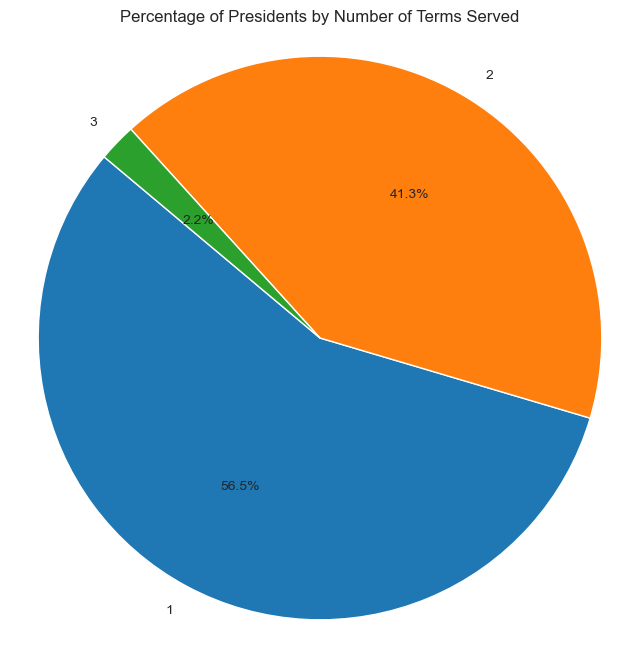

In [61]:
#Problem Statement 2 - What is the percentage of Presidents serving more than one term?

# Count the number of presidents for each number of terms
term_counts = president_df['Number of Terms'].value_counts()

# Calculate percentages
total_presidents = term_counts.sum()
percentages = (term_counts / total_presidents) * 100

# Plot the % of presidents for each number of terms
plt.figure(figsize=(8, 8))
sns.set_style("whitegrid")
sns.color_palette("pastel")
plt.pie(percentages, labels=percentages.index, autopct='%1.1f%%', startangle=140)
plt.title('Percentage of Presidents by Number of Terms Served')
plt.axis('equal')
plt.show()


<h3>Analysis of Question 2</h3>

<h4>Problem Statement - What is the percentage of Presidents serving more than one term?</h4>

<h4>Conclusion - approximitely 61 percent or almost two-thirds of all presidents served only 1 term, while the remaining 39 percent servers multiple.</h4>

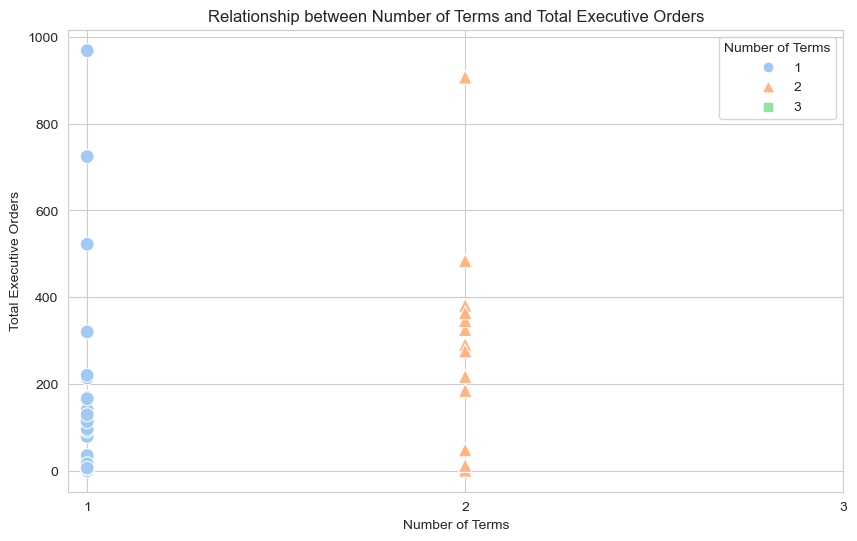

In [62]:
#Problem Statement 3 - Is there a relationship between the number of orders in a one term vs two term president?<

# Relationship between Number of Terms and Total Executive Orders
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
sns.scatterplot(data=president_df, x="Number of Terms", y="Total Executive Orders", hue="Number of Terms", palette="pastel", s=100, style="Number of Terms", markers=["o", "^", "s"])
# Set custom ticks for the x-axis
plt.xticks([1, 2.0, 3.0])

plt.title('Relationship between Number of Terms and Total Executive Orders')
plt.xlabel('Number of Terms')
plt.ylabel('Total Executive Orders')
plt.legend(title='Number of Terms')
plt.show()


<h3>Analysis of Question 3</h3>

<h4>Problem Statement - Is there a relationship between the number of orders in a one term vs two term president?</h4>

<h4>Conclusion - The only relationship I can deduce is when a president is provided a 2nd term the majority of them double their overall total.</h4>

In [63]:
#Problem Statement 4 - What is the avg number of executive orders by decade?, by party?

# Convert 'Term Start' to datetime format
president_df['Term Start'] = pd.to_datetime(president_df['Term Start'])

# Extract decade from 'Term Start'
president_df['Decade'] = president_df['Term Start'].dt.year // 10 * 10

# Group by decade and party, calculate the average number of executive orders
avg_orders_by_decade_party = president_df.groupby(['Decade', 'Party'])['Total Executive Orders'].mean().reset_index()

# Print the result
print(avg_orders_by_decade_party)


    Decade                  Party  Total Executive Orders
0     1780           Unaffiliated                8.000000
1     1790             Federalist                1.000000
2     1800  Democratic-Republican                2.500000
3     1810  Democratic-Republican                1.000000
4     1820             Democratic               12.000000
5     1820  Democratic-Republican                3.000000
6     1830             Democratic               10.000000
7     1840             Democratic               18.000000
8     1840                   Whig                7.333333
9     1850             Democratic               25.500000
10    1850                   Whig               12.000000
11    1860             Democratic               79.000000
12    1860             Republican              132.500000
13    1870             Republican               92.000000
14    1880             Democratic              113.000000
15    1880             Republican               81.666667
16    1890    

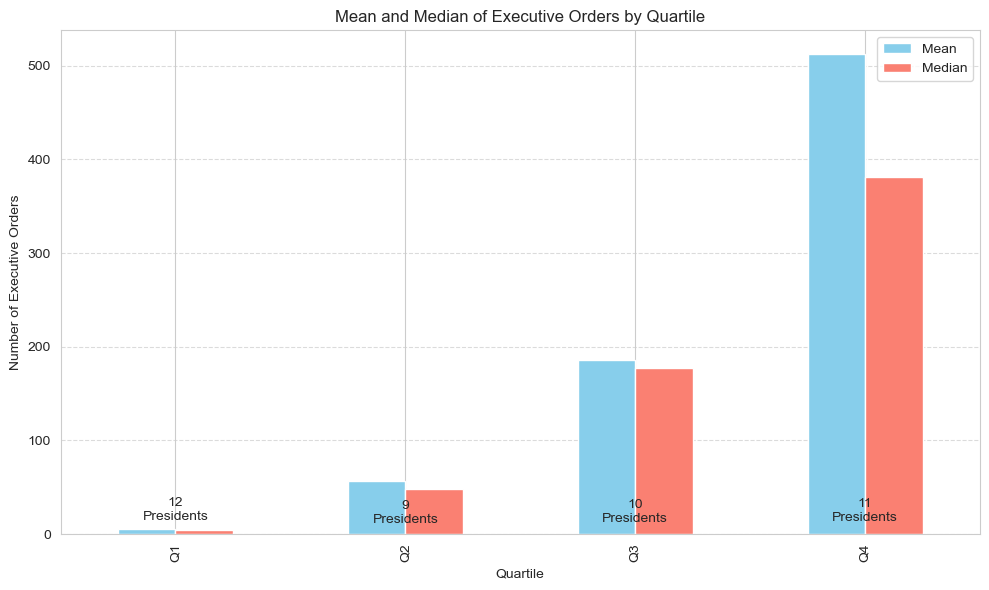

In [64]:
# Problem Statement 5 - Is there a relationship between the number of orders in a one term vs two term president?
# Calculate quartiles and assign quartile labels
quantiles = [0, 0.25, 0.5, 0.75, 1.0]
president_df['Quartile'] = pd.qcut(president_df["Total Executive Orders"], q=quantiles, labels=False)

# Count number of presidents per quartile
presidents_per_quartile = president_df['Quartile'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
ax = plt.gca()
mean_median_by_quartile.plot(kind='bar', ax=ax, color=['skyblue', 'salmon'])
plt.title('Mean and Median of Executive Orders by Quartile')
plt.xlabel('Quartile')
plt.ylabel('Number of Executive Orders')
plt.xticks(ticks=range(len(quantiles)-1), labels=[f'Q{i}' for i in range(1, len(quantiles))])
plt.legend(["Mean", "Median"])

# Inlay number of presidents per quartile
for i, v in enumerate(presidents_per_quartile):
    ax.text(i, v + 0.1, f'{v}\nPresidents', ha='center', va='bottom')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



<h3>Analysis of Question 5</h3>

<h4>Problem Statement - What is the number of executive orders by quartile, showing mean and median per?</h4>

<h4>Conclusion - This plot visualizes the mean and median number of executive orders issued by U.S. presidents, categorized into quartiles based on the total number of executive orders each president issued during their tenure.  By observing the distribution of mean and median executive orders across quartiles, you can understand the variation in the issuance of executive orders among different groups of presidents. The count of presidents in each quartile helps in understanding the number of presidents contributing to each segment of the distribution.</h4>